<a href="https://colab.research.google.com/github/salarrobot/Breast-Cancer-Classification/blob/main/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#─── 1) Imports & Reproducibility ───
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Seed everything for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#─── 2) GPU Check ───
print("Device:", tf.test.gpu_device_name() or "CPU")

#─── 3) Load Wisconsin Diagnostic Breast Cancer dataset from UCI ───
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-"
    "databases/breast-cancer-wisconsin/wdbc.data"
)

# define column names
feature_names = [
    "radius", "texture", "perimeter", "area", "smoothness",
    "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"
]
stats = ["mean", "se", "worst"]
columns = (
    ["ID", "Diagnosis"] +
    [f"{feat}_{stat}" for stat in stats for feat in feature_names]
)

Device: /device:GPU:0


In [4]:
# read into DataFrame
df = pd.read_csv(url, header=None, names=columns)


Shape: (569, 32)
Diagnosis
B    357
M    212
Name: count, dtype: int64 



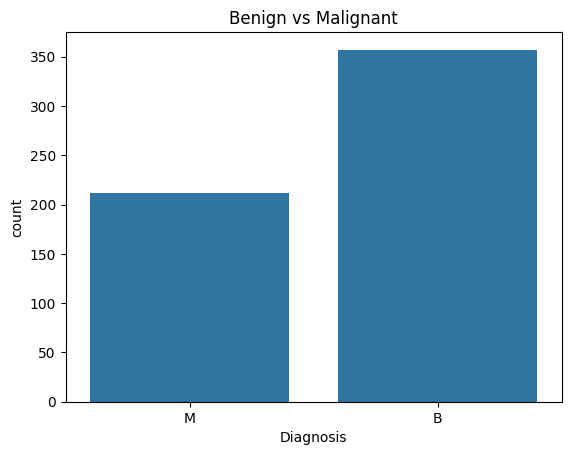

In [5]:
#─── 4) Quick EDA & Cleaning ───
print("Shape:", df.shape)
print(df['Diagnosis'].value_counts(), "\n")
sns.countplot(x='Diagnosis', data=df)
plt.title("Benign vs Malignant")
plt.show()

In [6]:
#─── 5) Encode & Split ───
# encode labels: B→0, M→1
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Diagnosis'])

# features and target
X = df.drop(columns=['ID', 'Diagnosis', 'Label'])
y = df['Label'].values

# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=SEED,
    stratify=y
)

In [7]:
#─── 6) Scale features ───
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [8]:
#─── 7) Build the Model ───
def build_model(input_dim):
    model = Sequential([
        Dense(32, input_dim=input_dim, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(X_train.shape[1])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729 (6.75 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 96 (384.00 B)

In [9]:
#─── 8) Callbacks ───
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint('best_breast_cancer_model.h5', save_best_only=True)
]

In [10]:
#─── 9) Train ───
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100


14/14 - 8s - 546ms/step - accuracy: 0.5775 - loss: 0.7231 - val_accuracy: 0.3846 - val_loss: 0.7110 - learning_rate: 1.0000e-03
Epoch 2/100


14/14 - 5s - 365ms/step - accuracy: 0.7746 - loss: 0.5096 - val_accuracy: 0.3986 - val_loss: 0.6909 - learning_rate: 1.0000e-03
Epoch 3/100


14/14 - 0s - 10ms/step - accuracy: 0.8521 - loss: 0.3869 - val_accuracy: 0.4685 - val_loss: 0.6687 - learning_rate: 1.0000e-03
Epoch 4/100


14/14 - 0s - 11ms/step - accuracy: 0.8991 - loss: 0.3390 - val_accuracy: 0.5175 - val_loss: 0.6432 - learning_rate: 1.0000e-03
Epoch 5/100


14/14 - 0s - 16ms/step - accuracy: 0.9038 - loss: 0.2994 - val_accuracy: 0.6014 - val_loss: 0.6154 - learning_rate: 1.0000e-03
Epoch 6/100


14/14 - 0s - 20ms/step - accuracy: 0.9272 - loss: 0.2814 - val_accuracy: 0.6573 - val_loss: 0.5843 - learning_rate: 1.0000e-03
Epoch 7/100


14/14 - 0s - 15ms/step - accuracy: 0.9249 - loss: 0.2698 - val_accuracy: 0.7273 - val_loss: 0.5530 - learning_rate: 1.0000e-03
Epoch 8/100


14/14 - 0s - 16ms/step - accuracy: 0.9296 - loss: 0.2483 - val_accuracy: 0.7902 - val_loss: 0.5235 - learning_rate: 1.0000e-03
Epoch 9/100


14/14 - 0s - 17ms/step - accuracy: 0.9413 - loss: 0.2259 - val_accuracy: 0.8252 - val_loss: 0.4872 - learning_rate: 1.0000e-03
Epoch 10/100


14/14 - 0s - 21ms/step - accuracy: 0.9437 - loss: 0.2091 - val_accuracy: 0.8601 - val_loss: 0.4549 - learning_rate: 1.0000e-03
Epoch 11/100


14/14 - 0s - 21ms/step - accuracy: 0.9390 - loss: 0.2068 - val_accuracy: 0.8741 - val_loss: 0.4240 - learning_rate: 1.0000e-03
Epoch 12/100


14/14 - 0s - 19ms/step - accuracy: 0.9507 - loss: 0.1843 - val_accuracy: 0.9021 - val_loss: 0.3845 - learning_rate: 1.0000e-03
Epoch 13/100


14/14 - 0s - 11ms/step - accuracy: 0.9531 - loss: 0.1746 - val_accuracy: 0.9301 - val_loss: 0.3480 - learning_rate: 1.0000e-03
Epoch 14/100


14/14 - 0s - 13ms/step - accuracy: 0.9554 - loss: 0.1721 - val_accuracy: 0.9371 - val_loss: 0.3163 - learning_rate: 1.0000e-03
Epoch 15/100


14/14 - 0s - 13ms/step - accuracy: 0.9554 - loss: 0.1709 - val_accuracy: 0.9441 - val_loss: 0.2877 - learning_rate: 1.0000e-03
Epoch 16/100


14/14 - 0s - 13ms/step - accuracy: 0.9460 - loss: 0.1793 - val_accuracy: 0.9580 - val_loss: 0.2626 - learning_rate: 1.0000e-03
Epoch 17/100


14/14 - 0s - 13ms/step - accuracy: 0.9554 - loss: 0.1601 - val_accuracy: 0.9580 - val_loss: 0.2425 - learning_rate: 1.0000e-03
Epoch 18/100


14/14 - 0s - 21ms/step - accuracy: 0.9601 - loss: 0.1521 - val_accuracy: 0.9580 - val_loss: 0.2250 - learning_rate: 1.0000e-03
Epoch 19/100


14/14 - 0s - 19ms/step - accuracy: 0.9742 - loss: 0.1417 - val_accuracy: 0.9510 - val_loss: 0.2062 - learning_rate: 1.0000e-03
Epoch 20/100


14/14 - 0s - 20ms/step - accuracy: 0.9648 - loss: 0.1473 - val_accuracy: 0.9510 - val_loss: 0.1901 - learning_rate: 1.0000e-03
Epoch 21/100


14/14 - 0s - 13ms/step - accuracy: 0.9671 - loss: 0.1259 - val_accuracy: 0.9720 - val_loss: 0.1727 - learning_rate: 1.0000e-03
Epoch 22/100


14/14 - 0s - 21ms/step - accuracy: 0.9742 - loss: 0.1235 - val_accuracy: 0.9720 - val_loss: 0.1566 - learning_rate: 1.0000e-03
Epoch 23/100


14/14 - 0s - 22ms/step - accuracy: 0.9577 - loss: 0.1395 - val_accuracy: 0.9790 - val_loss: 0.1456 - learning_rate: 1.0000e-03
Epoch 24/100


14/14 - 0s - 18ms/step - accuracy: 0.9765 - loss: 0.1155 - val_accuracy: 0.9790 - val_loss: 0.1364 - learning_rate: 1.0000e-03
Epoch 25/100


14/14 - 0s - 10ms/step - accuracy: 0.9624 - loss: 0.1277 - val_accuracy: 0.9790 - val_loss: 0.1271 - learning_rate: 1.0000e-03
Epoch 26/100


14/14 - 0s - 10ms/step - accuracy: 0.9601 - loss: 0.1164 - val_accuracy: 0.9790 - val_loss: 0.1194 - learning_rate: 1.0000e-03
Epoch 27/100


14/14 - 0s - 11ms/step - accuracy: 0.9624 - loss: 0.1193 - val_accuracy: 0.9860 - val_loss: 0.1138 - learning_rate: 1.0000e-03
Epoch 28/100


14/14 - 0s - 10ms/step - accuracy: 0.9812 - loss: 0.1076 - val_accuracy: 0.9860 - val_loss: 0.1102 - learning_rate: 1.0000e-03
Epoch 29/100


14/14 - 0s - 13ms/step - accuracy: 0.9695 - loss: 0.1019 - val_accuracy: 0.9860 - val_loss: 0.1082 - learning_rate: 1.0000e-03
Epoch 30/100


14/14 - 0s - 13ms/step - accuracy: 0.9765 - loss: 0.1028 - val_accuracy: 0.9860 - val_loss: 0.1057 - learning_rate: 1.0000e-03
Epoch 31/100


14/14 - 0s - 18ms/step - accuracy: 0.9765 - loss: 0.1006 - val_accuracy: 0.9860 - val_loss: 0.1021 - learning_rate: 1.0000e-03
Epoch 32/100


14/14 - 0s - 11ms/step - accuracy: 0.9695 - loss: 0.1014 - val_accuracy: 0.9860 - val_loss: 0.0979 - learning_rate: 1.0000e-03
Epoch 33/100


14/14 - 0s - 23ms/step - accuracy: 0.9765 - loss: 0.0989 - val_accuracy: 0.9790 - val_loss: 0.0962 - learning_rate: 1.0000e-03
Epoch 34/100
14/14 - 0s - 16ms/step - accuracy: 0.9742 - loss: 0.0980 - val_accuracy: 0.9720 - val_loss: 0.1033 - learning_rate: 1.0000e-03
Epoch 35/100
14/14 - 0s - 8ms/step - accuracy: 0.9859 - loss: 0.0893 - val_accuracy: 0.9650 - val_loss: 0.1070 - learning_rate: 1.0000e-03
Epoch 36/100
14/14 - 0s - 8ms/step - accuracy: 0.9742 - loss: 0.0959 - val_accuracy: 0.9650 - val_loss: 0.1059 - learning_rate: 1.0000e-03
Epoch 37/100
14/14 - 0s - 11ms/step - accuracy: 0.9812 - loss: 0.0841 - val_accuracy: 0.9650 - val_loss: 0.1029 - learning_rate: 1.0000e-03
Epoch 38/100
14/14 - 0s - 19ms/step - accuracy: 0.9695 - loss: 0.0973 - val_accuracy: 0.9650 - val_loss: 0.1008 - learning_rate: 1.0000e-03
Epoch 39/100


14/14 - 0s - 17ms/step - accuracy: 0.9859 - loss: 0.0871 - val_accuracy: 0.9720 - val_loss: 0.0938 - learning_rate: 5.0000e-04
Epoch 40/100


14/14 - 0s - 11ms/step - accuracy: 0.9812 - loss: 0.0765 - val_accuracy: 0.9720 - val_loss: 0.0905 - learning_rate: 5.0000e-04
Epoch 41/100
14/14 - 0s - 19ms/step - accuracy: 0.9789 - loss: 0.0877 - val_accuracy: 0.9720 - val_loss: 0.0921 - learning_rate: 5.0000e-04
Epoch 42/100
14/14 - 0s - 9ms/step - accuracy: 0.9812 - loss: 0.0798 - val_accuracy: 0.9720 - val_loss: 0.0914 - learning_rate: 5.0000e-04
Epoch 43/100
14/14 - 0s - 8ms/step - accuracy: 0.9718 - loss: 0.0931 - val_accuracy: 0.9720 - val_loss: 0.0929 - learning_rate: 5.0000e-04
Epoch 44/100
14/14 - 0s - 10ms/step - accuracy: 0.9836 - loss: 0.0751 - val_accuracy: 0.9720 - val_loss: 0.0919 - learning_rate: 5.0000e-04
Epoch 45/100
14/14 - 0s - 14ms/step - accuracy: 0.9789 - loss: 0.0908 - val_accuracy: 0.9720 - val_loss: 0.0928 - learning_rate: 5.0000e-04
Epoch 46/100
14/14 - 0s - 15ms/step - accuracy: 0.9859 - loss: 0.0763 - val_accuracy: 0.9720 - val_loss: 0.0945 - learning_rate: 2.5000e-04
Epoch 47/100
14/14 - 0s - 10ms/step

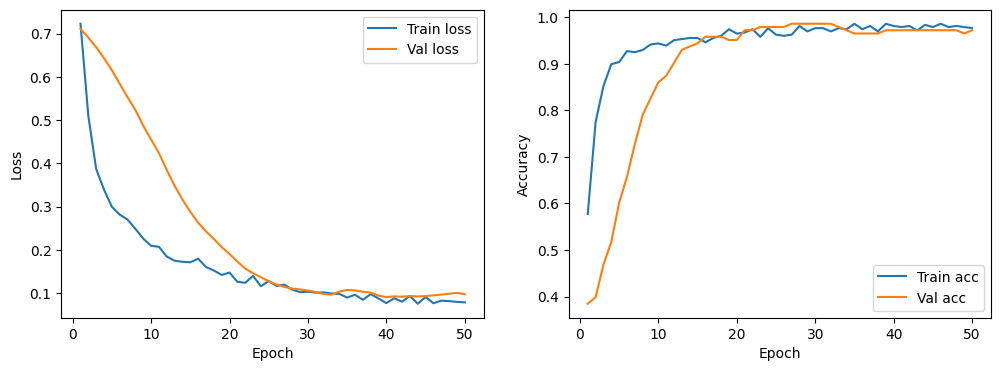

In [11]:
#─── 10) Plot Loss & Accuracy ───
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history.history['loss'], label='Train loss')
plt.plot(epochs, history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history.history['accuracy'], label='Train acc')
plt.plot(epochs, history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        90
           M       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



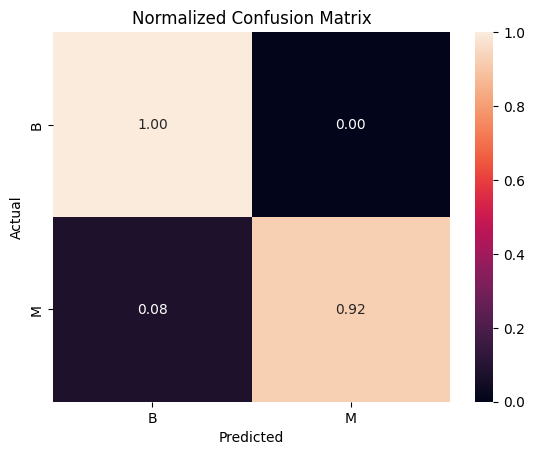

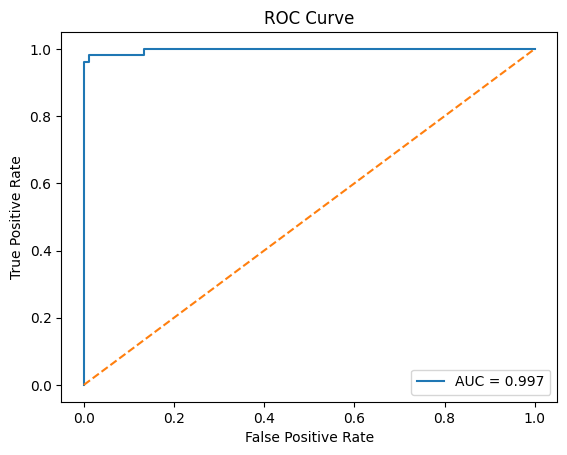

In [12]:
#─── 11) Evaluation ───
# predictions & ROC
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

# classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# ROC curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()